In [1]:
#@title Imports & Utils

!pip install -q jax-md

import imageio
import jax.numpy as jnp
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns
from jax_md import space
from jax_md.colab_tools import renderer
import jax
import numpy as np

sns.set_style(style='white')
background_color = [56 / 256] * 3
colours = jnp.array([
    [125, 148, 181],
    # [200, 183, 166],
    [194, 149, 145],
    # [112, 63, 55],
    # [182, 193, 153],
]) / 255

def make_chains(box_size, num_1d, chain_length):
  displacement_fn, shift_fn = space.periodic(box_size)
  _1d_pos = jnp.linspace(0, box_size, num_1d + 1)[:num_1d]
  _1d_pos += 0.5 * box_size / num_1d
  num_chains_lengthwise = num_1d // chain_length


  def chain_data(atom_index, start_x, start_y):
    chain_positions_x = start_x + jnp.linspace(
        0, box_size / num_chains_lengthwise, chain_length + 1
    )[:-1]
    chain_position_y = jnp.ones(chain_length) * start_y
    chain_positions = jnp.stack([chain_positions_x, chain_position_y]).T
    chain_bonds = jnp.stack([
        atom_index + jnp.arange(chain_length - 1),
        atom_index + jnp.arange(1, chain_length),
    ]).T
    num_chain_angle_bonds = chain_length - 2
    chain_angle_bonds = jnp.stack([
        atom_index + jnp.arange(0, chain_length - 2),
        atom_index + jnp.arange(1, chain_length - 1),
        atom_index + jnp.arange(2, chain_length - 0),
    ]).T
    species = [0, 0, 1]
    chain_angle_species = jnp.array(species, dtype=jnp.int32)
    atom_species = jnp.array([0] + species + [0], dtype=jnp.int32)
    chain_atom_colors = colours[atom_species]
    return (
        jnp.mod(chain_positions, box_size),
        chain_bonds,
        chain_angle_bonds,
        chain_angle_species,
        chain_atom_colors,
    )


  def make_row_of_chains(atom_index, start_y):
    start_y = start_y.repeat(num_chains_lengthwise)
    atom_indices = atom_index + jnp.arange(num_chains_lengthwise) * chain_length
    start_x = _1d_pos[::chain_length] + 2 * start_y
    out = jax.vmap(chain_data)(atom_indices, start_x, start_y)
    reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
    return jax.tree_map(reshape, out)

  row = jax.vmap(make_row_of_chains)(num_1d * jnp.arange(num_1d), _1d_pos)
  reshape = lambda arr: arr.reshape(np.prod(arr.shape[:2]), *arr.shape[2:])
  return displacement_fn, shift_fn, *jax.tree_map(reshape, row)

In [2]:
#@title SMAP Bond Angles
from jax_md.smap import _kwargs_to_bond_parameters, high_precision_sum
from typing import Callable, Optional, Dict, Union
from jax_md import util
from functools import partial

Array = util.Array

DisplacementOrMetricFn = space.DisplacementOrMetricFn

f32 = util.f32


# LR: edited jax_md.smap.bond, this is intended to work on an array with all
# atoms with two bonds
def bond_angles(fn: Callable[..., Array],
         displacement_or_metric: DisplacementOrMetricFn,
         static_bonds: Optional[Array]=None,
         static_bond_types: Optional[Array]=None,
         ignore_unused_parameters: bool=False,
         **kwargs) -> Callable[..., Array]:
  """Promotes a function that acts on a single pair to one on a set of bonds.

  TODO(schsam): It seems like bonds might potentially have poor memory access.
  Should think about this a bit and potentially optimize.

  Args:
    fn: A function that takes an ndarray of pairwise distances or displacements
      of shape `[n, m]` or `[n, m, d_in]` respectively as well as kwargs
      specifying parameters for the function. `fn` returns an ndarray of
      evaluations of shape `[n, m, d_out]`.
    metric: A function that takes two ndarray of positions of shape
      `[spatial_dimension]` and `[spatial_dimension]` respectively and returns
      an ndarray of distances or displacements of shape `[]` or `[d_in]`
      respectively. The metric can optionally take a floating point time as a
      third argument.
    static_bonds: An ndarray of integer pairs wth shape `[b, 2]` where each
      pair specifies a bond. `static_bonds` are baked into the returned compute
      function statically and cannot be changed after the fact.
    static_bond_types: An ndarray of integers of shape `[b]` specifying the
      type of each bond. Only specify bond types if you want to specify bond
      parameters by type. One can also specify constant or per-bond parameters
      (see below).
    ignore_unused_parameters: A boolean that denotes whether dynamically
      specified keyword arguments passed to the mapped function get ignored
      if they were not first specified as keyword arguments when calling
      `smap.bond(...)`.
    kwargs: Arguments providing parameters to the mapped function. In cases
      where no bond type information is provided these should be either

        1. a scalar
        2. an ndarray of shape `[b]`.

      If bond type information is provided then the parameters should be
      specified as either

        1. a scalar
        2. an ndarray of shape `[max_bond_type]`.
        3. a ParameterTree containing a PyTree of parameters and a mapping. See
           ParameterTree for details.
  Returns:
    A function `fn_mapped`. Note that `fn_mapped` can take arguments bonds and
    `bond_types` which will be bonds that are specified dynamically. This will
    incur a recompilation when the number of bonds changes. Improving this
    state of affairs I will leave as a TODO until someone actually uses this
    feature and runs into speed issues.
  """

  # Each call to vmap adds a single batch dimension. Here, we would like to
  # promote the metric function from one that computes the distance /
  # displacement between two vectors to one that acts on two lists of vectors.
  # Thus, we apply a single application of vmap.

  merge_dicts = partial(util.merge_dicts,
                        ignore_unused_parameters=ignore_unused_parameters)

  def compute_fn(R, bonds, bond_types, static_kwargs, dynamic_kwargs):
    Ra = R[bonds[:, 0]]
    Rb = R[bonds[:, 1]]
    Rc = R[bonds[:, 2]]
    _kwargs = merge_dicts(static_kwargs, dynamic_kwargs)
    _kwargs = _kwargs_to_bond_parameters(bond_types, _kwargs)
    # NOTE(schsam): This pattern is needed due to JAX issue #912.
    d = jax.vmap(partial(displacement_or_metric, **dynamic_kwargs), 0, 0)
    dr = d(Ra, Rb, Rc)
    return high_precision_sum(fn(dr, **_kwargs))

  def mapped_fn(R: Array,
                bonds: Optional[Array]=None,
                bond_types: Optional[Array]=None,
                **dynamic_kwargs) -> Array:
    accum = f32(0)

    if bonds is not None:
      accum = accum + compute_fn(R, bonds, bond_types, kwargs, dynamic_kwargs)

    if static_bonds is not None:
      accum = accum + compute_fn(
          R, static_bonds, static_bond_types, kwargs, dynamic_kwargs)

    return accum
  return mapped_fn

In [3]:
from jax_md import smap


class ChainHyp:
  strength = 1000.0
  radius = jnp.array(1.0)
  k_r = 10.0
  k_theta = 10.0
  r_eq = 1.1224594 * 1.000001
  theta_eq = jnp.array([0.0, jnp.pi * 0.5])


def chain_energy_components(displacement_fn, chain_hyp):
  def bond(r):
    return chain_hyp.k_r * (r - chain_hyp.r_eq) ** 2

  def bond_angle_energy(theta, species):
    return chain_hyp.k_theta * (theta - chain_hyp.theta_eq[species]) ** 2

  eps = 1e-4
  def angle_metric(ra, rb, rc):
    rab = displacement_fn(rb, ra)
    rbc = displacement_fn(rc, rb)
    rab /= jnp.linalg.norm(rab)
    rbc /= jnp.linalg.norm(rbc)
    sin = rab[0] * rbc[1] - rbc[0] * rab[1]
    cos = rab[0] * rbc[0] + rab[1] * rbc[1]
    return jnp.arctan2(sin, cos)

  def non_bonded(rs):
    return energy.soft_sphere(
        rs, sigma=chain_hyp.radius, epsilon=chain_hyp.strength
    )

  return {
      "bond": {"energy": bond, "metric": displacement_fn},
      "angle": {"energy": bond_angle_energy, "metric": angle_metric},
      "non_bonded": {"energy": non_bonded, "metric": displacement_fn}
  }


def create_chain_energy(energy_functions):

  def bond_energy(pos):
    bond_functions = energy_functions["bond"]
    bond_type = None
    return smap.bond(
      bond_functions["energy"],
      space.canonicalize_displacement_or_metric(bond_functions["metric"]),
      bonds,
      bond_type,
    )(pos)

  def angle_energy(pos):
    angle_functions = energy_functions["angle"]
    static_bond_types = None
    return bond_angles(
      partial(angle_functions["energy"], species=bond_species),
      angle_functions["metric"],
      bonds_for_angle,
      static_bond_types,
    )(pos)

  # def softsphere(positions):
  #   return energy.soft_sphere_pair(
  #       displacement_fn, sigma=radius, epsilon=strength
  #   )(positions)

  def soft_sphere(pos):
    non_bonded_functions = energy_functions["non_bonded"]
    return smap.pair(
      non_bonded_functions["energy"],
      space.canonicalize_displacement_or_metric(non_bonded_functions["metric"]),
    )(pos)

  def total_chain_energy(positions):
    return (
        soft_sphere(positions) + bond_energy(positions) + angle_energy(positions)
    )
  return total_chain_energy

In [4]:
box_size = 100.0
displacement_fn, shift_fn, positions, bonds, bonds_for_angle, bond_species, colors = make_chains(
    box_size=box_size, num_1d=40, chain_length=5
)
chain_hyp = ChainHyp()
energy_functions = chain_energy_components(displacement_fn, chain_hyp)
total_chain_energy = create_chain_energy(energy_functions)

Text(0, 0.5, '$\\epsilon$')

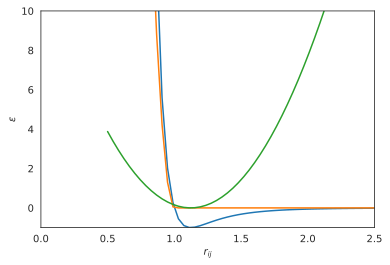

In [5]:
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))
plt.plot(rs, energy_functions["non_bonded"]["energy"](rs))
plt.plot(rs, energy_functions["bond"]["energy"](rs))

plt.ylim([-1, 10])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

Text(0, 0.5, 'recovered theta')

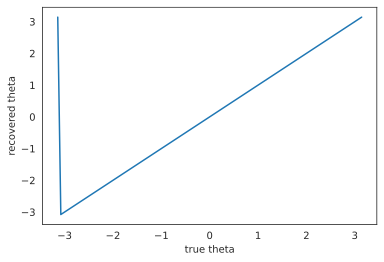

In [6]:
t = jnp.linspace(-jnp.pi, jnp.pi, 100)
ra = jnp.array([0, 0])
rb = jnp.array([1, 0])
rc = jnp.array([1, 0])[None, :] + jnp.stack([jnp.cos(t), jnp.sin(t)]).T

plt.plot(t, [energy_functions["angle"]["metric"](ra, rb, rc_) for rc_ in rc])
plt.xlabel('true theta')
plt.ylabel('recovered theta')

In [7]:
from jax_md import minimize
from jax import jit

def run_minimization(energy_fn, R_init, shift, num_steps=50):
  dt_start = 0.001
  dt_max   = 0.004
  init, apply = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=dt_start, dt_max=dt_max
  )
  apply = jit(apply)

  @jit
  def scan_fn(state, i):
    return apply(state), 0.

  state = init(R_init)
  state, _ = jax.lax.scan(scan_fn,state,np.arange(num_steps))

  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position)))

k = jax.random.PRNGKey(seed=0)
position_noise = jax.random.normal(k, shape=positions.shape) * 0.3
noisy_positions = positions + position_noise
positions_relaxed, max_force_component = run_minimization(
    total_chain_energy, noisy_positions, shift_fn
)

/usr/local/lib/python3.8/dist-packages/jax/_src/numpy/reductions.py:206: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


In [8]:
from jax_md import simulate
from jax_md import dataclasses
from jax import lax



@dataclasses.dataclass
class Chains:
  chains: simulate.NVTLangevinState

simulation_steps = 10000
write_every = 50
write_steps = simulation_steps // write_every

init_fn, step_fn = simulate.nvt_langevin(total_chain_energy, shift_fn, dt=5e-3, kT=0.0)


def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory
  traj = Chains(traj.chains.at[i].set(state.chains.position))

  def total_step_fn(_, state): return Chains(step_fn(state.chains))

  state = lax.fori_loop(0, write_every, total_step_fn, state)
  return state, traj

n = positions_relaxed.shape[0]

key = jax.random.PRNGKey(seed=0)

# position_start = jnp.mod(positions_relaxed + 0.1742 * box_size, box_size)
position_start = jnp.mod(positions_relaxed, box_size)

state = Chains(init_fn(key, position_start),)
trajectory = Chains(jnp.zeros((write_steps, n, 2)),)

state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (state, trajectory))
print(
    f"original positions potential energy: {total_chain_energy(positions)};\n"
    f"noisy positions potential energy: {total_chain_energy(noisy_positions)};\n"
    f"relaxed positions potential energy: {total_chain_energy(position_start)};\n"
    f"final positions potential energy: {total_chain_energy(state.chains.position)};\n"
)

# This is very bizarre, I get weird artifacts due to the PBC, even though I offset the start positions...
# The chains seem to cluster in the middle... this geometry implies that it must be the PBC / forces across the PBC somehow... Could it be that I have the incorrect number density??
renderer.render(
    box_size,
    {
        'chains': renderer.Disk(
            trajectory.chains,
            jnp.ones(positions.shape[0]) * chain_hyp.radius,
            color=colors,
        ),
    },
    resolution=(800, 800),
)

original positions potential energy: 32185.15625;
noisy positions potential energy: 36795.78125;
relaxed positions potential energy: 25307.224609375;
final positions potential energy: 48.675235748291016;



This is with a stochastic NVT routine. The PE is initially high, this increases KE, then PE becomes low, then so does KE.

In [10]:
# from jax import grad
# g = grad(angle_full_energy)(positions)
# int(jnp.isnan(g).sum()), np.prod(g.shape)

Before/after: noise, relaxation, etc.

In [11]:
# print(total_chain_energy(positions))
# renderer.render(box_size, renderer.Disk(positions, color=colors))

In [12]:
# print(total_chain_energy(positions + position_noise))
# renderer.render(box_size, renderer.Disk(positions + position_noise, color=colors))

In [13]:
# print(total_chain_energy(positions_relaxed))
# renderer.render(box_size, renderer.Disk(positions_relaxed, color=colors))

...trying the deterministic NVT simulation routine...

In [14]:
from jax_md import simulate
from jax_md import dataclasses
from jax import lax

class DeterministicChainHyp:
  dt = 5e-5
  kT  = 0.1
  tau = 100
dchyp = DeterministicChainHyp()

@dataclasses.dataclass
class Chains:
  chains: simulate.NVTNoseHooverState

simulation_steps = 30_000 # ~3 min for 100K steps
write_every = 100
write_steps = simulation_steps // write_every

init_fn, step_fn = simulate.nvt_nose_hoover(
    total_chain_energy,
    shift_fn,
    dt=dchyp.dt,
    kT=dchyp.kT,
    tau=dchyp.tau,
)


def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory
  traj = Chains(traj.chains.at[i].set(state.chains.position))

  def total_step_fn(_, state):
    return Chains(step_fn(state.chains))
  state = lax.fori_loop(0, write_every, total_step_fn, state)
  return state, traj


def run(start_positions):
  state, traj = lax.fori_loop(
      0,
      write_steps,
      simulation_fn,
      (
          Chains(init_fn(key, start_positions)),
          Chains(jnp.zeros((write_steps, n, 2))),
      ),
  )
  return traj

In [15]:
n = positions_relaxed.shape[0]
key = jax.random.PRNGKey(seed=0)

In [16]:
noisy_trajectory = run(noisy_positions)

In [17]:
positions_relaxed, max_force_component = run_minimization(
    total_chain_energy, positions, shift_fn, num_steps=5000,
)
position_start = jnp.mod(positions_relaxed + 0.742 * box_size, box_size)

relaxed_trajectory = run(position_start)

```
Chains(chains=NVTNoseHooverState(position=DeviceArray([[24.279488 , 19.040083 ],
             [25.364399 , 18.77306  ],
             [26.446714 , 18.510086 ],
             ...,
             [ 8.893394 , 15.636658 ],
             [ 9.9711685, 15.352989 ],
             [10.249733 , 16.43966  ]], dtype=float32), momentum=DeviceArray([[ 0.35368586, -0.07232902],
             [ 0.03376019, -0.19361225],
             [ 0.51767534, -0.53123635],
             ...,
             [-0.12139791,  0.24531819],
             [ 0.11786256,  0.08953138],
             [ 0.18024476,  0.14501336]], dtype=float32), force=DeviceArray([[-0.113167  , -0.0269571 ],
             [-0.06784172,  0.01532302],
             [-0.00480634,  0.02986831],
             ...,
             [-0.00475042,  0.02989049],
             [ 0.04516122, -0.00628788],
             [ 0.11409527, -0.01574294]], dtype=float32), mass=DeviceArray(1., dtype=float32), chain=NoseHooverChain(position=DeviceArray([0., 0., 0., 0., 0.], dtype=float32), momentum=DeviceArray([0., 0., 0., 0., 0.], dtype=float32), mass=DeviceArray([3.2e+06, 1.0e+03, 1.0e+03, 1.0e+03, 1.0e+03], dtype=float32), tau=DeviceArray(100., dtype=float32), kinetic_energy=DeviceArray(157.94955, dtype=float32), degrees_of_freedom=3200)))
```



In [18]:
renderer.render(
    box_size,
    {
        'chains': renderer.Disk(
            noisy_trajectory.chains,
            jnp.ones(positions.shape[0]) * chain_hyp.radius,
            color=colors,
        ),
    },
    resolution=(800, 800),
)

In [19]:
renderer.render(
    box_size,
    {
        'chains': renderer.Disk(
            relaxed_trajectory.chains,
            jnp.ones(positions.shape[0]) * chain_hyp.radius,
            color=colors,
        ),
    },
    resolution=(800, 800),
)

...I mainly just did this for debugging

In [74]:
def run_minimization_record(energy_fn, R_init, shift, num_steps=50, write_every=1):
  dt_start = 0.001
  dt_max   = 0.004
  init, apply = minimize.fire_descent(
      jit(energy_fn), shift, dt_start=dt_start, dt_max=dt_max
  )
  apply = jit(apply)

  write_steps = num_steps // write_every

  def simulation_fn(i, state_trajectory):
    state, traj = state_trajectory
    traj = traj.at[i].set(state.position)

    def total_step_fn(_, state): return apply(state)

    state = lax.fori_loop(0, write_every, total_step_fn, state)
    return state, traj

  state_trajectory = (init(R_init), jnp.zeros((write_steps,) + R_init.shape))
  state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, state_trajectory)
  return state.position, np.amax(np.abs(-jax.grad(energy_fn)(state.position))), trajectory


# positions_relaxed, max_force_component, em_traj = run_minimization_record(
#     total_chain_energy, positions, shift_fn, num_steps=1000, write_every=10,
# )

In [21]:
# renderer.render(
#     box_size,
#     {
#         'chains': renderer.Disk(
#             jnp.mod(em_traj + box_size * 0.5, box_size),
#             jnp.ones(positions.shape[0]) * chain_hyp.radius,
#             color=colors,
#         ),
#     },
#     resolution=(800, 800),
# )

In [22]:
def compute_error():
  print(positions.shape)
  dists = jnp.linalg.norm(
      jax.vmap(
          jax.vmap(displacement_fn, in_axes=(0, None)),
          in_axes=(None, 0)
      )(positions, positions),
      axis=-1,
  )
  sorted = jnp.sort(dists, axis=-1)
  self_, updown_neighbours, diag_neighbours = sorted[:, 0], sorted[:, 1:5], sorted[:, 5:9]
  return {
      "self": jnp.abs(self_ - jnp.zeros_like(self_)).sum(),
      "updown_neighbours": jnp.abs(updown_neighbours - jnp.ones_like(updown_neighbours) * updown_neighbours[0, 0]).sum(),
      "diag_neighbours": jnp.abs(diag_neighbours - jnp.ones_like(diag_neighbours) * diag_neighbours[0, 0]).sum(),
  }
# compute_error()

In [23]:
from jax_md import quantity

class DeterministicHyp:
  epsilon = 1000
  N = 400
  dimension = 2
  dt = 5e-3
  kT_initial = 0.1
  kT_final = 0.01
  species_radii = [1.0, 1.4]
  number_density = 0.6

dhyp = DeterministicHyp()
kT = lambda t: jnp.where(t < 5000.0 * dhyp.dt, dhyp.kT_initial, dhyp.kT_final)

In [24]:
box_size = quantity.box_size_at_number_density(
    dhyp.N, dhyp.number_density, dhyp.dimension
)
displacement, shift = space.periodic(box_size) 

In [25]:
box_size

DeviceArray(25.81989, dtype=float32, weak_type=True)

In [26]:
dhyp.N * box_size ** -2

DeviceArray(0.59999996, dtype=float32, weak_type=True)

In [27]:
key = jax.random.PRNGKey(0)
key, split = jax.random.split(key)
R = box_size * jax.random.uniform(
    split, (dhyp.N, dhyp.dimension), dtype=jnp.float64
)

# The system ought to be a 50:50 mixture of two types of particles, one
# large and one small.
sigma = jnp.array([[dhyp.species_radii[0], 1.2], [1.2, dhyp.species_radii[1]]])
N_2 = int(dhyp.N / 2)
species = jnp.where(np.arange(dhyp.N) < N_2, 0, 1)

soft_sphere_pair + nvt_nose_hoover

In [28]:
energy_fn = energy.soft_sphere_pair(
    displacement, species=species, sigma=sigma, epsilon=dhyp.epsilon
)

init, apply = simulate.nvt_nose_hoover(energy_fn, shift, dhyp. dt, kT(0.))
state = init(key, R)

In [29]:
position, max_force_component = run_minimization(energy_fn, state.position, shift)
state = simulate.NVTNoseHooverState(
    position=position,
    momentum=state.momentum,
    force=state.force,
    mass=state.mass,
    chain=state.chain
)

In [30]:
write_every = 100

def step_fn(i, state_and_log):
  state, log = state_and_log

  t = i * dhyp.dt

  # Log information about the simulation.
  T = quantity.temperature(momentum=state.momentum)
  log['kT'] = log['kT'].at[i].set(T)
  H = simulate.nvt_nose_hoover_invariant(energy_fn, state, kT(t))
  log['H'] = log['H'].at[i].set(H)
  # Record positions every `write_every` steps.
  log['position'] = lax.cond(i % write_every == 0,
                             lambda p: \
                             p.at[i // write_every].set(state.position),
                             lambda p: p,
                             log['position'])

  # Take a simulation step.
  state = apply(state, kT=kT(t))
  
  return state, log

In [31]:
steps = 10000

log = {
    'kT': jnp.zeros((steps,)),
    'H': jnp.zeros((steps,)),
    'position': jnp.zeros((steps // write_every,) + R.shape) 
}

state, log = lax.fori_loop(0, steps, step_fn, (state, log))

R = state.position

In [32]:
log["position"].shape

(100, 400, 2)

In [33]:
renderer.render(
    box_size,
    {
        'chains': renderer.Disk(
            log["position"],
            jnp.array(dhyp.species_radii)[species],
            color=colours[species],
        ),
    },
    resolution=(800, 800),
)